# NESTML inhomogeneous Poisson generator tutorial

In this tutorial, we formulate a NESTML model for an inhomogeneous Poisson process [1], and simulate it in NEST Simulator.

The rate of the model is piecewise constant and is defined by an array containing desired rates (in units of 1/s) and an array of equal length containing the corresponding times (in units of ms). Please see the documentation for the NEST built-in inhomogeneous_poisson_generator for more details [2].

## Preliminaries

The inhomogeneous Poisson model is defined in the file ``inhomogeneous_poisson.nestml``. We call NESTML to generate and build the code, so the model can be instantiated in NEST Simulator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
from scipy.signal import convolve
import time
from sklearn.linear_model import LinearRegression
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

/home/charl/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-rc1
 Built: Feb 21 2024 09:04:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# generate and build code
module_name, neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("inhomogeneous_poisson.nestml")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5.0-rc1
 Built: Feb 21 2024 09:04:08

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.1!=4.10.1
[12,inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml, WARNING, [1:0;26:0]]: Input block not defined!
[13,inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml, WARNING, [9:8;9:20]]: Variable 'N' has the same name as a physical unit!
[17,inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml, WARNING, [1:0;26:0]]: Input block not defined!
[18,inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml, WARNING, [9:8;9:20]]: Variable 'N' has the same name as a physical unit!
CMake Warning (dev) at CMake

First, we generate a random piecewise constant target rate, that we want to feed into the Poisson generator model.

In [3]:
def generate_input(num_steps, step_duration, resolution, distr_max, distr_min=0.):
    """
    Generates a piecewise constant input signal with amplitudes drawn from a uniform distribution

    Parameters
    ----------
    num_steps: int
        number of steps in the step function
    step_duration: int
        duration of each step in ms
    resolution: float
        resolution of the generated signal

    Returns
    -------
 The rate   ndarray
        continuous input signal (between distr_min and distr_max)
    ndarray
        time vector with all the times for which the signal is generated
    ndarray
        times at which signal amplitude shifts
    ndarray
        amplitudes
    """
    dist_range = [distr_min, distr_max]
    rand_distr = np.random.uniform(low=dist_range[0], high=dist_range[1], size=num_steps)
    rand_distr = rand_distr + abs(min(dist_range))
    inp_times = np.arange(resolution, num_steps * step_duration, step_duration)
    time_vec = np.arange(0, num_steps * step_duration + resolution, resolution)
    signal = np.zeros_like(time_vec)
    for tt in range(len(inp_times)):
        end_idx = int(round(inp_times[tt + 1] / resolution)) if tt + 1 < len(inp_times) else None
        signal[int(round(inp_times[tt] / resolution)):end_idx] = rand_distr[tt]

    return signal, time_vec, inp_times, rand_distr

Text(0, 0.5, 'Rate [s${}^{-1}$]')

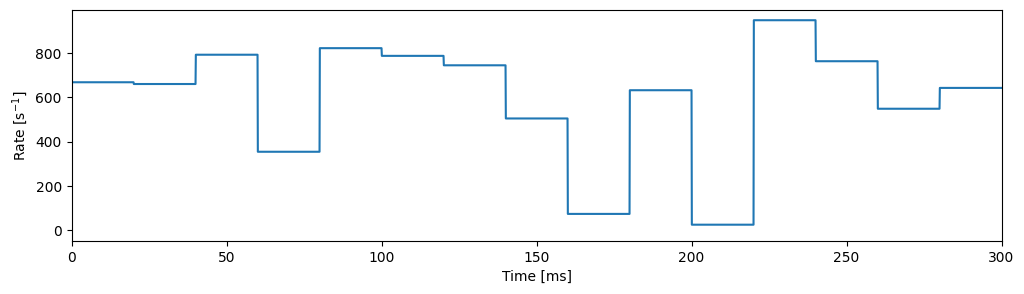

In [4]:
step_duration = 20.   # duration of each step [ms]
num_steps = 15        # number of unique input values
dt = .1               # simulation resolution [ms]

rate, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps,
                                                        step_duration=step_duration,
                                                        resolution=dt,
                                                        distr_max=1000.)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(times, rate)
ax.set_xlim([0, num_steps * step_duration])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Rate [s${}^{-1}$]")

## Simulating the models

With the NESTML model loaded into the NEST kernel, we are ready to run the simulation. We define a helper function to run the simulation for each model: the NEST built-in inhomogeneous Poisson generator, and the one created in NESTML. We simulate ``n_instances`` (default: 100) of each model and compute the achieved average rate based on the simulation. The rates from the simulation (plotted below in red) should match the target rates (in blue). Events (spikes) emitted from eac model are additionally plotted in a rastergram.

In [5]:
def simulate_poisson_model(neuron_model, input_times, input_amplitudes, sig, n_instances=100, seed=1, dt=.1):
    sim_time = num_steps*step_duration
    
    np.random.seed(seed)
    nest.ResetKernel()
    nest.Install(module_name)
    nest.SetKernelStatus({'rng_seed': seed, 'resolution': dt, 'print_time': True})    

    # create inhomogeneous poisson generator (time-dependent input signal)
    stim_pgen = nest.Create(neuron_model, n_instances)
    stim_pgen_params = {'rate_times': input_times, 'rate_values': input_amplitudes}
    if "N" in stim_pgen.get().keys():
        stim_pgen_params['N'] = len(input_times)
    nest.SetStatus(stim_pgen, params=stim_pgen_params)

    sr = nest.Create('spike_recorder')
    nest.Connect(stim_pgen, sr)
    
    nest.Simulate(sim_time)
    
    activity = nest.GetStatus(sr, 'events')[0]

    rate_estimated, rate_estimated_bin_edges = np.histogram(activity['times'], bins=100)
    rate_estimated_bin_centers = (rate_estimated_bin_edges[:-1] + rate_estimated_bin_edges[1:]) / 2
    bin_width = np.diff(rate_estimated_bin_centers)[0]
    rate = rate_estimated / bin_width
    rate /= n_instances
    rate *= 1E3

    # Plot
    fig = plt.figure(figsize=(20, 5))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(activity['times'], activity['senders'], '.k', markersize=1)
    ax11.set_xlim([0., sim_time])
    ax11.set_ylabel("Neuron")

    ax12.plot(times, sig, linewidth=2)
    ax12.plot(rate_estimated_bin_centers, rate, linewidth=2, c='red')
    ax12.set_ylabel("Rate [s${}^{-1}$]")
    ax12.set_xlabel(r'Time [ms]')
    plt.show()

    return activity['times'], activity['senders']

### NEST reference model

First, check that the NEST built-in inhomogeneous Poisson generator is working as expected.


Feb 24 09:08:40 inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 24 09:08:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 24 09:08:40 NodeManager::prepare_nodes [Info]: 
    Preparing 101 nodes for simulation.

Feb 24 09:08:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 101
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 300.0 ms, Real-time factor: 0.0905

Feb 24 09:08:40 SimulationManager::run [Info]: 
    Simulation finished.


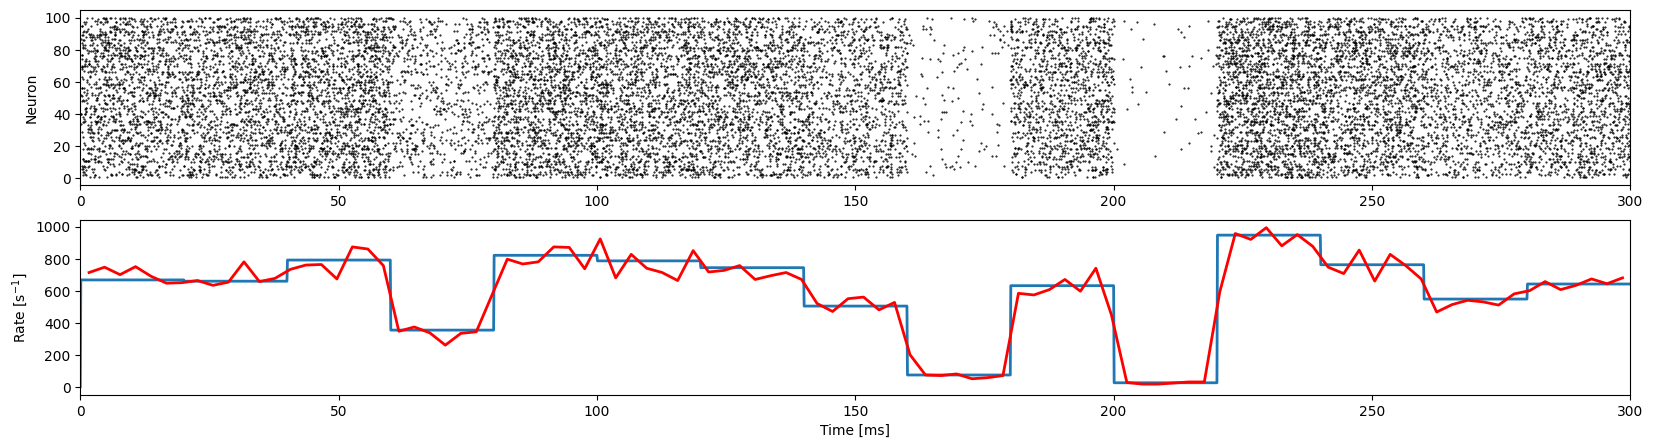

In [6]:
_ = simulate_poisson_model("inhomogeneous_poisson_generator", inp_times, inp_amplitudes, rate, dt=dt)

### NESTML model

Next, verify that the NESTML model is working correctly.


Feb 24 09:08:40 inhomogeneous_poisson09101de42ae44e479610c36e4cc709f5_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 24 09:08:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 24 09:08:40 NodeManager::prepare_nodes [Info]: 
    Preparing 101 nodes for simulation.

Feb 24 09:08:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 101
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Not using MPI

[ 100% ] Model time: 300.0 ms, Real-time factor: 0.0372ms, Real-time factor: 0.0369

Feb 24 09:08:40 SimulationManager::run [Info]: 
    Simulation finished.


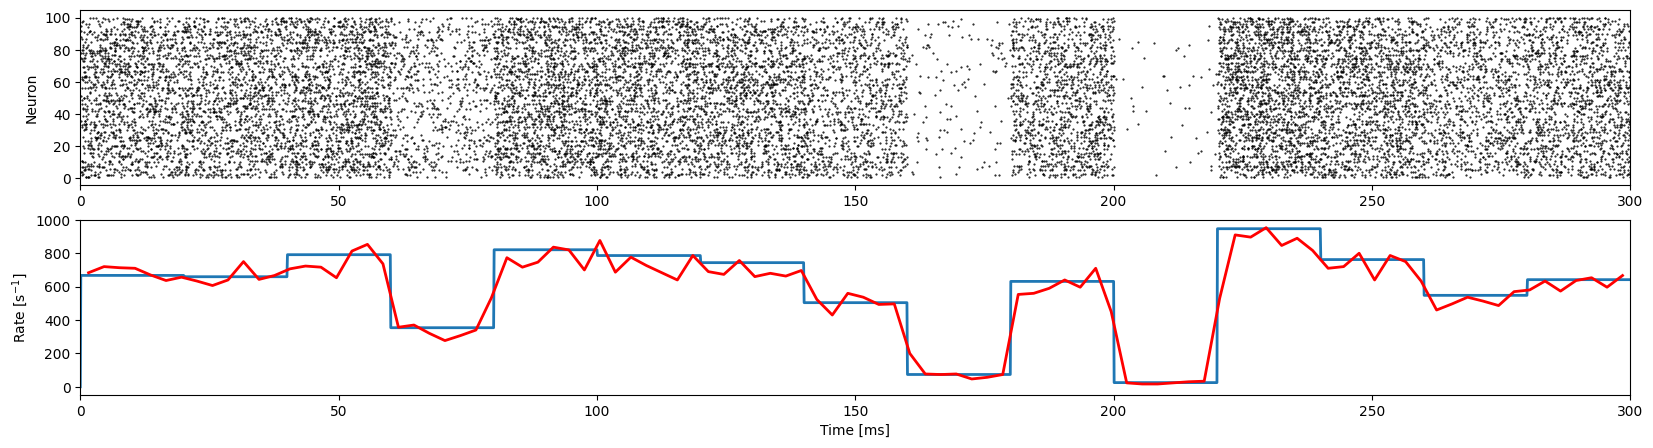

In [7]:
_ = simulate_poisson_model(neuron_model_name, inp_times, inp_amplitudes, rate, dt=dt)

References
----------

[1] Wikipedia contributors. 'Poisson Point Process.' Wikipedia, The Free Encyclopedia. Accessed on February 23, 2024. https://en.wikipedia.org/wiki/Poisson_point_process.

[2] https://nest-simulator.readthedocs.io/en/stable/models/inhomogeneous_poisson_generator.html


Acknowledgements
----------------

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270, No. 785907 and No. 945539 (Human Brain Project SGA1, SGA2 and SGA3).


License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.